In [1]:
from dotenv import load_dotenv

load_dotenv()

False

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

In [3]:
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode, tools_condition

checkpointer = MemorySaver()

graph_builder = StateGraph(State)


@tool
def get_weather(location: str):
    """Call to get the current weather."""
    if location.lower() in ["munich"]:
        return "It's 15 degrees Celsius and cloudy."
    else:
        return "It's 32 degrees Celsius and sunny."


@tool
def broken_api(location: str):
    """Call to get the current weather."""
    return f"Currently no weather data available for {location}. Please try again later"


tools = [get_weather, broken_api]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [4]:
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("chatbot")
graph = graph_builder.compile(
    checkpointer=checkpointer,
    interrupt_before=["tools"],
)

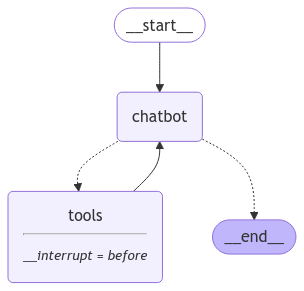

In [33]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [6]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Hello, I am John")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='Hello, I am John', additional_kwargs={}, response_metadata={}, id='0b00df08-e39a-4631-91ca-3c42e9ce6e21'),
  AIMessage(content='Hello John! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 70, 'total_tokens': 82, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-3945b7a7-5843-41b6-83f4-618ea87e07f5-0', usage_metadata={'input_tokens': 70, 'output_tokens': 12, 'total_tokens': 82, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}

In [7]:
config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(content="Sorry, did I already introduce myself?")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='Sorry, did I already introduce myself?', additional_kwargs={}, response_metadata={}, id='461eb400-496e-4bff-9430-fc848c6b7e9d'),
  AIMessage(content="No, you haven't introduced yourself yet! Please feel free to share your name or anything else you'd like me to know about you.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 73, 'total_tokens': 101, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-55ecd774-5e52-4e1f-a4be-b575f3f7f5da-0', usage_metadata={'input_tokens': 73, 'output_tokens': 28, 'total_tokens': 101, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0,

In [8]:
config = {"configurable": {"thread_id": "1"}}
input_message = HumanMessage(content="Sorry, did I already introduce myself?")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='Hello, I am John', additional_kwargs={}, response_metadata={}, id='0b00df08-e39a-4631-91ca-3c42e9ce6e21'),
  AIMessage(content='Hello John! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 70, 'total_tokens': 82, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'stop', 'logprobs': None}, id='run-3945b7a7-5843-41b6-83f4-618ea87e07f5-0', usage_metadata={'input_tokens': 70, 'output_tokens': 12, 'total_tokens': 82, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
  HumanMessage(content='Sorry, did I already introduce myself?', additional_kwargs={}, resp

In [9]:
snapshot = graph.get_state(config)
snapshot.next

()

In [10]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "3"}}
input_message = HumanMessage(content="How is the weather in Munich?")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='c349cad5-a02e-4fc7-9658-1f1bbc8d2f1c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qxtICoZkzXX7GTbMLWCMYE2F', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-be6f2bbd-3a80-4a7b-82dd-2552939cc971-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_qxtICoZkzXX7GTbMLWCMYE2F', 'type': 'tool_call'}], usage_metadata={

In [11]:
snapshot = graph.get_state(config)
snapshot.next

('tools',)

In [12]:
graph.invoke(None, config=config)

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='c349cad5-a02e-4fc7-9658-1f1bbc8d2f1c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qxtICoZkzXX7GTbMLWCMYE2F', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-be6f2bbd-3a80-4a7b-82dd-2552939cc971-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_qxtICoZkzXX7GTbMLWCMYE2F', 'type': 'tool_call'}], usage_metadata={

### Timetravel

In [13]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="How is the weather in Munich?")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='c0ab3dc0-b82a-44c8-8242-085f55b7c652'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-44e23285-c5a2-4334-b346-5c554cfd434a-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'type': 'tool_call'}], usage_metadata={

In [14]:
snapshot = graph.get_state(config)
existing_message = snapshot.values["messages"][-1]
existing_message.pretty_print()

================================== Ai Message ==================================
Tool Calls:
  get_weather (call_mYhSOOyAZbh62tolgzJEqwdy)
 Call ID: call_mYhSOOyAZbh62tolgzJEqwdy
  Args:
    location: Munich


In [15]:
from langchain_core.messages import AIMessage, ToolMessage

answer = "It is only 5°C warm today!"
new_messages = [
    ToolMessage(content=answer, tool_call_id=existing_message.tool_calls[0]["id"]),
    AIMessage(content=answer),
]
graph.update_state(
    config,
    {"messages": new_messages},
)

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe94fe-feab-60a3-8002-e2bc7599c21b'}}

In [16]:
print((graph.get_state(config).values["messages"]))

[HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='c0ab3dc0-b82a-44c8-8242-085f55b7c652'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-44e23285-c5a2-4334-b346-5c554cfd434a-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'type': 'tool_call'}], usage_metadata={'input_tokens':

In [17]:
config = {"configurable": {"thread_id": "4"}}
input_message = HumanMessage(content="How warm was it again?")

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='c0ab3dc0-b82a-44c8-8242-085f55b7c652'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-44e23285-c5a2-4334-b346-5c554cfd434a-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'type': 'tool_call'}], usage_metadata={

### Replay

In [18]:
all_checkpoints = []
for state in graph.get_state_history(config=config):
    all_checkpoints.append(state)
all_checkpoints

[StateSnapshot(values={'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='c0ab3dc0-b82a-44c8-8242-085f55b7c652'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-44e23285-c5a2-4334-b346-5c554cfd434a-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'type': 'tool_call'

In [19]:
to_replay = all_checkpoints[4]
to_replay.values

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='c0ab3dc0-b82a-44c8-8242-085f55b7c652'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-44e23285-c5a2-4334-b346-5c554cfd434a-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'type': 'tool_call'}], usage_metadata={

In [20]:
to_replay.next

('tools',)

In [21]:
to_replay.config

{'configurable': {'thread_id': '4',
  'checkpoint_ns': '',
  'checkpoint_id': '1efe94fe-3570-6b93-8001-e7792c73e56d'}}

In [22]:
graph.invoke(None, config=to_replay.config)

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='c0ab3dc0-b82a-44c8-8242-085f55b7c652'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-44e23285-c5a2-4334-b346-5c554cfd434a-0', tool_calls=[{'name': 'get_weather', 'args': {'location': 'Munich'}, 'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'type': 'tool_call'}], usage_metadata={

### Branching off past state

In [23]:
last_message = to_replay.values["messages"][-1]

In [24]:
last_message.tool_calls

[{'name': 'get_weather',
  'args': {'location': 'Munich'},
  'id': 'call_mYhSOOyAZbh62tolgzJEqwdy',
  'type': 'tool_call'}]

In [25]:
last_message.tool_calls[0]["name"] = "broken_api"
last_message.tool_calls

[{'name': 'broken_api',
  'args': {'location': 'Munich'},
  'id': 'call_mYhSOOyAZbh62tolgzJEqwdy',
  'type': 'tool_call'}]

In [26]:
branch_config = graph.update_state(
    to_replay.config,
    {"messages": [last_message]},
)

In [27]:
graph.invoke(None, branch_config)

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='c0ab3dc0-b82a-44c8-8242-085f55b7c652'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-44e23285-c5a2-4334-b346-5c554cfd434a-0', tool_calls=[{'name': 'broken_api', 'args': {'location': 'Munich'}, 'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'type': 'tool_call'}], usage_metadata={'

In [28]:
graph.invoke(None, config=config)

{'messages': [HumanMessage(content='How is the weather in Munich?', additional_kwargs={}, response_metadata={}, id='c0ab3dc0-b82a-44c8-8242-085f55b7c652'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'function': {'arguments': '{"location":"Munich"}', 'name': 'get_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 72, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-44e23285-c5a2-4334-b346-5c554cfd434a-0', tool_calls=[{'name': 'broken_api', 'args': {'location': 'Munich'}, 'id': 'call_mYhSOOyAZbh62tolgzJEqwdy', 'type': 'tool_call'}], usage_metadata={'

### Wait for user input

In [29]:
from typing import Annotated

from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]
    ask_human: bool

In [30]:
from langchain_core.tools import tool


@tool
def request_assistance():
    """Escalate the conversation to an expert. Use this if you are unable to assist directly or if the user requires support beyond your permissions.

    To use this function, relay the user's 'request' so the expert can provide the right guidance.
    """
    return ""

In [31]:
tools = [get_weather]
llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = llm.bind_tools(tools + [request_assistance])


def chatbot(state: State):
    response = llm_with_tools.invoke(state["messages"])
    ask_human = False
    if response.tool_calls and response.tool_calls[0]["name"] == "request_assistance":
        ask_human = True
    return {"messages": [response], "ask_human": ask_human}

In [34]:
graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", ToolNode(tools=tools))

In [36]:
from langchain_core.messages import AIMessage, ToolMessage


def create_response(response: str, ai_message: AIMessage):
    return ToolMessage(
        content=response,
        tool_call_id=ai_message.tool_calls[0]["id"],
    )


def human_node(state: State):
    new_messages = []
    if not isinstance(state["messages"][-1], ToolMessage):
        new_messages.append(
            create_response(
                "Plan your trip 3 months before and you don´t carry a Real Madrid shirt with you",
                state["messages"][-1],
            )
        )
    return {
        "messages": new_messages,
        "ask_human": False,
    }


graph_builder.add_node("human", human_node)

In [37]:
def select_next_node(state: State):
    if state["ask_human"]:
        return "human"
    return tools_condition(state)


graph_builder.add_conditional_edges(
    "chatbot",
    select_next_node,
    {"human": "human", "tools": "tools", "__end__": "__end__"},
)

In [38]:
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge("human", "chatbot")
graph_builder.set_entry_point("chatbot")
checkpointer = MemorySaver()
graph = graph_builder.compile(
    checkpointer=checkpointer,
    interrupt_before=["human"],
)

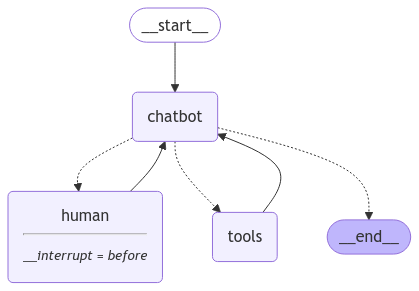

In [39]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [40]:
config = {"configurable": {"thread_id": "50"}}
input_message = HumanMessage(
    content="I need some expert advice on how to plan a trip to barcelona"
)

graph.invoke({"messages": input_message}, config=config)

{'messages': [HumanMessage(content='I need some expert advice on how to plan a trip to barcelona', additional_kwargs={}, response_metadata={}, id='3439075c-b746-469e-8574-c9aed18ccef7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QGs0jUU3aBMi8flb7MBOqsmW', 'function': {'arguments': '{}', 'name': 'request_assistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 115, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1785a490-d608-44f9-b4c6-be4fc3ccfd0f-0', tool_calls=[{'name': 'request_assistance', 'args': {}, 'id': 'call_QGs0jUU3aBMi8flb7MBOqsmW', 'type': 'tool_call'}], usage_me

In [41]:
graph.invoke(None, config=config)

{'messages': [HumanMessage(content='I need some expert advice on how to plan a trip to barcelona', additional_kwargs={}, response_metadata={}, id='3439075c-b746-469e-8574-c9aed18ccef7'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QGs0jUU3aBMi8flb7MBOqsmW', 'function': {'arguments': '{}', 'name': 'request_assistance'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 115, 'total_tokens': 127, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_72ed7ab54c', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1785a490-d608-44f9-b4c6-be4fc3ccfd0f-0', tool_calls=[{'name': 'request_assistance', 'args': {}, 'id': 'call_QGs0jUU3aBMi8flb7MBOqsmW', 'type': 'tool_call'}], usage_me

### New way Human in the loop - Interrupt + Command

In [42]:
from typing import TypedDict
from typing_extensions import Literal
from langgraph.graph import END, StateGraph
from langgraph.types import Command


class InputState(TypedDict):
    string_value: str
    numeric_value: int


def modify_state(input_state: InputState) -> InputState:
    input_state["string_value"] += "a"
    input_state["numeric_value"] += 1
    return input_state


def branch_a(state: InputState) -> Command[Literal["branch_b"]]:
    print(f"branch_a: Current state: {state}")
    new_state = modify_state(state)
    print(f"branch_a: Updated state: {new_state}")
    return Command(
        goto="branch_b",
        update=new_state,
    )


def branch_b(state: InputState) -> Command[Literal["branch_c"]]:
    print(f"branch_b: Current state: {state}")
    new_state = modify_state(state)
    print(f"branch_b: Updated state: {new_state}")
    return Command(
        goto="branch_c",
        update=new_state,
    )


def branch_c(state: InputState) -> Command[Literal[END]]:
    print(f"branch_c: Current state: {state}")
    new_state = modify_state(state)
    print(f"branch_c: Updated state: {new_state}")
    return Command(goto=END, update=new_state)

In [43]:
graph = StateGraph(InputState)

graph.add_node("branch_a", branch_a)
graph.add_node("branch_b", branch_b)
graph.add_node("branch_c", branch_c)
graph.set_entry_point("branch_a")

runnable = graph.compile()

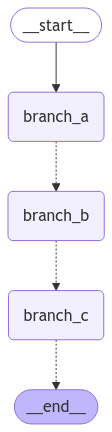

In [44]:
from IPython.display import Image, display

try:
    display(Image(runnable.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [45]:
initial_state = {"string_value": "Hello", "numeric_value": 0}
final_state = runnable.invoke(initial_state)

print("Final state:", final_state)

branch_a: Current state: {'string_value': 'Hello', 'numeric_value': 0}
branch_a: Updated state: {'string_value': 'Helloa', 'numeric_value': 1}
branch_b: Current state: {'string_value': 'Helloa', 'numeric_value': 1}
branch_b: Updated state: {'string_value': 'Helloaa', 'numeric_value': 2}
branch_c: Current state: {'string_value': 'Helloaa', 'numeric_value': 2}
branch_c: Updated state: {'string_value': 'Helloaaa', 'numeric_value': 3}
Final state: {'string_value': 'Helloaaa', 'numeric_value': 3}


In [46]:
from typing_extensions import Literal
from langgraph.graph import StateGraph, END, MessagesState
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import Command, interrupt
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from IPython.display import Image, display


@tool
def weather_search(city: str):
    """Search for the weather in a specific city"""
    print("----")
    print(f"Searching for: {city}")
    print("----")
    return "Sunny!"


model = ChatOpenAI(model="gpt-4o-mini").bind_tools([weather_search])


def call_llm(state):
    return {"messages": [model.invoke(state["messages"])]}


def human_review_node(state) -> Command[Literal["call_llm", "run_tool"]]:
    last_message = state["messages"][-1]
    tool_call = last_message.tool_calls[-1]

    human_review = interrupt(
        {
            "question": "Is this correct?",
            "tool_call": tool_call,
        }
    )
    print("Human review values:", human_review)

    review_action = human_review["action"]
    review_data = human_review.get("data")

    if review_action == "continue":
        return Command(goto="run_tool")

    elif review_action == "update":
        updated_message = {
            "role": "ai",
            "content": last_message.content,
            "tool_calls": [
                {
                    "id": tool_call["id"],
                    "name": tool_call["name"],
                    "args": review_data,
                }
            ],
            "id": last_message.id,
        }
        return Command(goto="run_tool", update={"messages": [updated_message]})


def route_after_llm(state) -> Literal[END, "human_review_node"]:
    if len(state["messages"][-1].tool_calls) == 0:
        return END
    else:
        return "human_review_node"


builder = StateGraph(MessagesState)
builder.add_node("call_llm", call_llm)
builder.add_node("run_tool", ToolNode(tools=[weather_search]))
builder.add_node("human_review_node", human_review_node)
builder.add_conditional_edges("call_llm", route_after_llm)
builder.add_edge("run_tool", "call_llm")
builder.set_entry_point("call_llm")

memory = MemorySaver()

graph = builder.compile(checkpointer=memory)

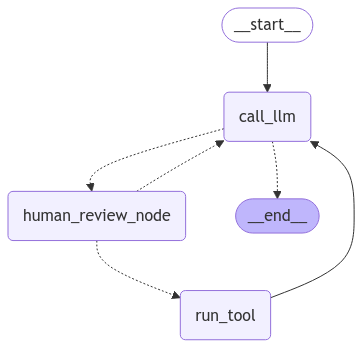

In [47]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [48]:
initial_input = {"messages": [HumanMessage(content="How is the weather in Munic?")]}
config = {"configurable": {"thread_id": "5"}}

first_result = graph.invoke(initial_input, config=config, stream_mode="updates")
first_result

[{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_H1dhuzZaZYBuviJjyBGRn03Z', 'function': {'arguments': '{"city":"Munic"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 54, 'total_tokens': 70, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f849d2e2-1c11-41a8-85d7-547a2714c649-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'Munic'}, 'id': 'call_H1dhuzZaZYBuviJjyBGRn03Z', 'type': 'tool_call'}], usage_metadata={'input_tokens': 54, 'output_tokens': 16, 'total_tokens': 70, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_detai

In [49]:
print(graph.get_state(config).next)

('human_review_node',)


In [50]:
graph.invoke(Command(resume={"action": "continue"}), config=config)

Human review values: {'action': 'continue'}
----
Searching for: Munic
----


{'messages': [HumanMessage(content='How is the weather in Munic?', additional_kwargs={}, response_metadata={}, id='8f83c36d-f552-405d-b0b1-e9dae504a79a'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_H1dhuzZaZYBuviJjyBGRn03Z', 'function': {'arguments': '{"city":"Munic"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 54, 'total_tokens': 70, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-f849d2e2-1c11-41a8-85d7-547a2714c649-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'Munic'}, 'id': 'call_H1dhuzZaZYBuviJjyBGRn03Z', 'type': 'tool_call'}], usage_metadata={'inpu

In [51]:
config = {"configurable": {"thread_id": "6"}}

graph.invoke(initial_input, config=config, stream_mode="updates")

[{'call_llm': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_HdBwNe0Q3r7xJTctbfTUbsho', 'function': {'arguments': '{"city":"Munich"}', 'name': 'weather_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 54, 'total_tokens': 70, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bd83329f63', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-b755a486-2b1c-4855-9449-aeee04eb5715-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'Munich'}, 'id': 'call_HdBwNe0Q3r7xJTctbfTUbsho', 'type': 'tool_call'}], usage_metadata={'input_tokens': 54, 'output_tokens': 16, 'total_tokens': 70, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_det

In [52]:
print(graph.get_state(config).next)

('human_review_node',)


In [53]:
graph.invoke(Command(resume={"action": "update", "data": {"city": "Munich"}}), config)

Human review values: {'action': 'update', 'data': {'city': 'Munich'}}
----
Searching for: Munich
----


{'messages': [HumanMessage(content='How is the weather in Munic?', additional_kwargs={}, response_metadata={}, id='8f83c36d-f552-405d-b0b1-e9dae504a79a'),
  AIMessage(content='', additional_kwargs={}, response_metadata={}, id='run-b755a486-2b1c-4855-9449-aeee04eb5715-0', tool_calls=[{'name': 'weather_search', 'args': {'city': 'Munich'}, 'id': 'call_HdBwNe0Q3r7xJTctbfTUbsho', 'type': 'tool_call'}]),
  ToolMessage(content='Sunny!', name='weather_search', id='3092b2f6-3370-4bdf-a587-3520de6dc5a8', tool_call_id='call_HdBwNe0Q3r7xJTctbfTUbsho'),
  AIMessage(content='The weather in Munich is sunny!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 79, 'total_tokens': 88, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerp